In [1]:
library(ggplot2)
library(readxl)
library(dplyr)
library(lmerTest)
library(tidyr)


Attaching package: 'dplyr'


The following objects are masked from 'package:stats':

    filter, lag


The following objects are masked from 'package:base':

    intersect, setdiff, setequal, union


Warning message:
"package 'lmerTest' was built under R version 4.1.2"
Loading required package: lme4

Loading required package: Matrix


Attaching package: 'lmerTest'


The following object is masked from 'package:lme4':

    lmer


The following object is masked from 'package:stats':

    step



Attaching package: 'tidyr'


The following objects are masked from 'package:Matrix':

    expand, pack, unpack




In [2]:
df_rob_b = data.frame(read_excel("Result_indi_roberta_base.xlsx"))
df_ber_b = data.frame(read_excel("Result_indi_bert_base.xlsx"))
df_ele_l = data.frame(read_excel("Result_indi_electra_large.xlsx"))
df_ern = data.frame(read_excel("Result_indi_ernie.xlsx"))
df_mac_b = data.frame(read_excel("Result_indi_macbert_base.xlsx"))
df_mac_l = data.frame(read_excel("Result_indi_macbert_large.xlsx"))

New names:
* `` -> ...1

New names:
* `` -> ...1

New names:
* `` -> ...1

New names:
* `` -> ...1

New names:
* `` -> ...1

New names:
* `` -> ...1



In [3]:
df_rob_b2 <- df_rob_b %>% mutate(model = "RoBERTa-base")
df_ber_b2 <- df_ber_b %>% mutate(model = "BERT-base")
df_ele_l2 <- df_ele_l %>% mutate(model = "ELECTRA-large")
df_ern2 <- df_ern %>% mutate(model = "ERNIE 1.0")
df_mac_b2 <- df_mac_b %>% mutate(model = "MacBERT-base")
df_mac_l2 <- df_mac_l %>% mutate(model = "MacBERT-large")

In [4]:
df_read <- rbind(rbind(rbind(rbind(rbind(df_rob_b2,df_ber_b2), df_ele_l2),df_ern2),df_mac_b2),df_mac_l2)
df_read$telic = substr(df_read$Verb,1,1)

df_raw <- df_read %>% dplyr::select(-MaskedSentence) %>% mutate(surp_ba = -log(df_read$prob_ba + exp(-30), base = 2))%>%
mutate(surp_bei = -log(df_read$prob_bei + exp(-30), base = 2))%>% mutate(diff_babei = surp_ba - surp_bei) %>%
mutate(telic = case_when(telic == 's' ~ 'spatial',TRUE ~ 'temporal')) %>% filter(Condition != "NP2_4cha" & Condition != "NP2_2cha")

df_raw <- df_raw %>% mutate(Condition = case_when(Condition == 'NP1_com' ~ 'C_cl/P',
                                                  Condition == 'NP2_com' ~ 'P/C_cl',
                                                  Condition == 'NP1_2cha' ~ 'C/P',
                                                  Condition == 'NP1_4cha' ~ 'C_cl/C_cl',
                                                  TRUE ~ 'P/P'))
head(df_raw,3)
unique(df_raw$Condition)
unique(df_raw$model)

,...1,Verb,Condition,prob_ba,prob_bei,model,telic,surp_ba,surp_bei,diff_babei
,<dbl>,<chr>,<chr>,<dbl>,<dbl>,<chr>,<chr>,<dbl>,<dbl>,<dbl>
1,0,t-da,P/C_cl,0.1814156,0.6124651,RoBERTa-base,temporal,2.462630,0.7073005,1.7553293
2,1,t-zou,P/C_cl,0.4688937,0.3266346,RoBERTa-base,temporal,1.092667,1.6142507,-0.5215835
3,2,t-ma,P/C_cl,0.3603301,0.4974927,RoBERTa-base,temporal,1.472609,1.0072526,0.4653563


[1] "P/C_cl"    "C_cl/P"    "C/P"       "C_cl/C_cl" "P/P"

[1] "RoBERTa-base"  "BERT-base"     "ELECTRA-large" "ERNIE 1.0"    
[5] "MacBERT-base"  "MacBERT-large"

## plot B_LMs for spatially telic context:

`summarise()` has grouped output by 'Condition'. You can override using the `.groups` argument.



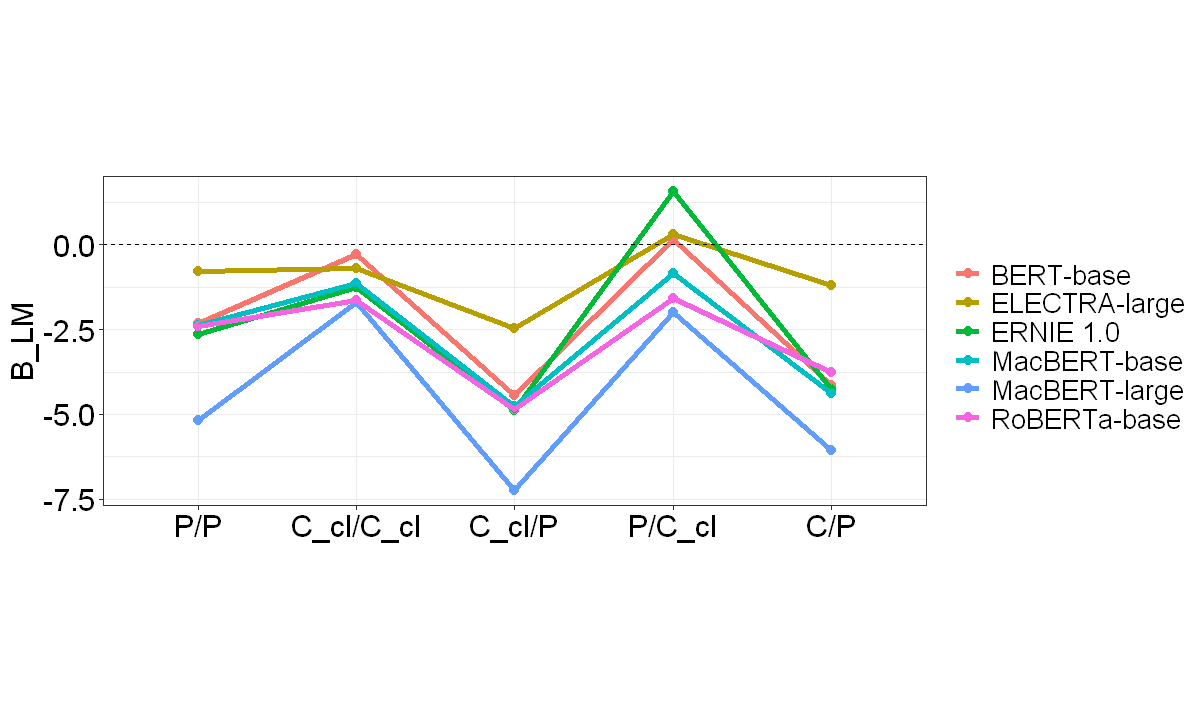

In [8]:
df_plot <- df_raw %>% filter(telic == "spatial") %>% group_by(Condition, model)%>% summarise(Mean = mean(diff_babei))
options(repr.plot.width=10, repr.plot.height=6)

level = c("P/P","C_cl/C_cl","C_cl/P", "P/C_cl" ,  "C/P")

plot_indi_spa <- ggplot(df_plot, aes(x = factor(Condition,levels = level), y = Mean, color = model, group = model)) +
   geom_point(size = 2.5) + geom_line(size= 1.5) + theme_bw() + 
theme(axis.text.x = element_text(size=18,color = "black"), 
      axis.title.x = element_blank(),
      axis.text.y = element_text(size=18,color = "black"),  
      axis.title.y = element_text(size = 18, color = "black"),
      legend.text = element_text(size= 16), 
      legend.title=element_blank(),
      aspect.ratio = 4/10) + 
labs(y = "B_LM") +
geom_hline(aes(yintercept = 0), linetype="dashed")

plot_indi_spa
# ggsave(file="ind.svg", plot= plot_indi_spa, width=10, height=6)

In [10]:
# ba vs. bei in the NP1_4cha-condition for model "RoBERTa-base":

df_mod_m <- df_raw %>% filter(telic == "spatial") %>% gather(BABEI, Value, surp_ba:surp_bei)

m_mod <- lmer(Value ~ BABEI   + (1|Verb) , data = df_mod_m %>% filter(Condition == "C_cl/C_cl" & model == "RoBERTa-base")) 
data.frame(coef(summary(m_mod)))

boundary (singular) fit: see ?isSingular



,Estimate,Std..Error,df,t.value,Pr...t..
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
(Intercept),0.9049864,0.3275512,16,2.762885,0.013861803
BABEIsurp_bei,1.6495011,0.4632273,16,3.560889,0.002605872
